In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pathlib
from pathlib import Path

directory_raw = str(Path.cwd().parent) + '/data_raw/'

directory_processed = str(Path.cwd().parent) + '/data'
directory_raw

'/Users/brentondickerson/git/breathe/data_raw/'

In [2]:
def read_data(file_name):
    # data = pl.from_pandas(pd.read_csv(directory_raw+'/'+file_name))
    data = pl.from_pandas(pd.read_csv(directory_raw + file_name))
    return data

def save_data(data, file_name):
    data.write_csv(directory_processed + file_name)
    print(f"{file_name} has been saved.")

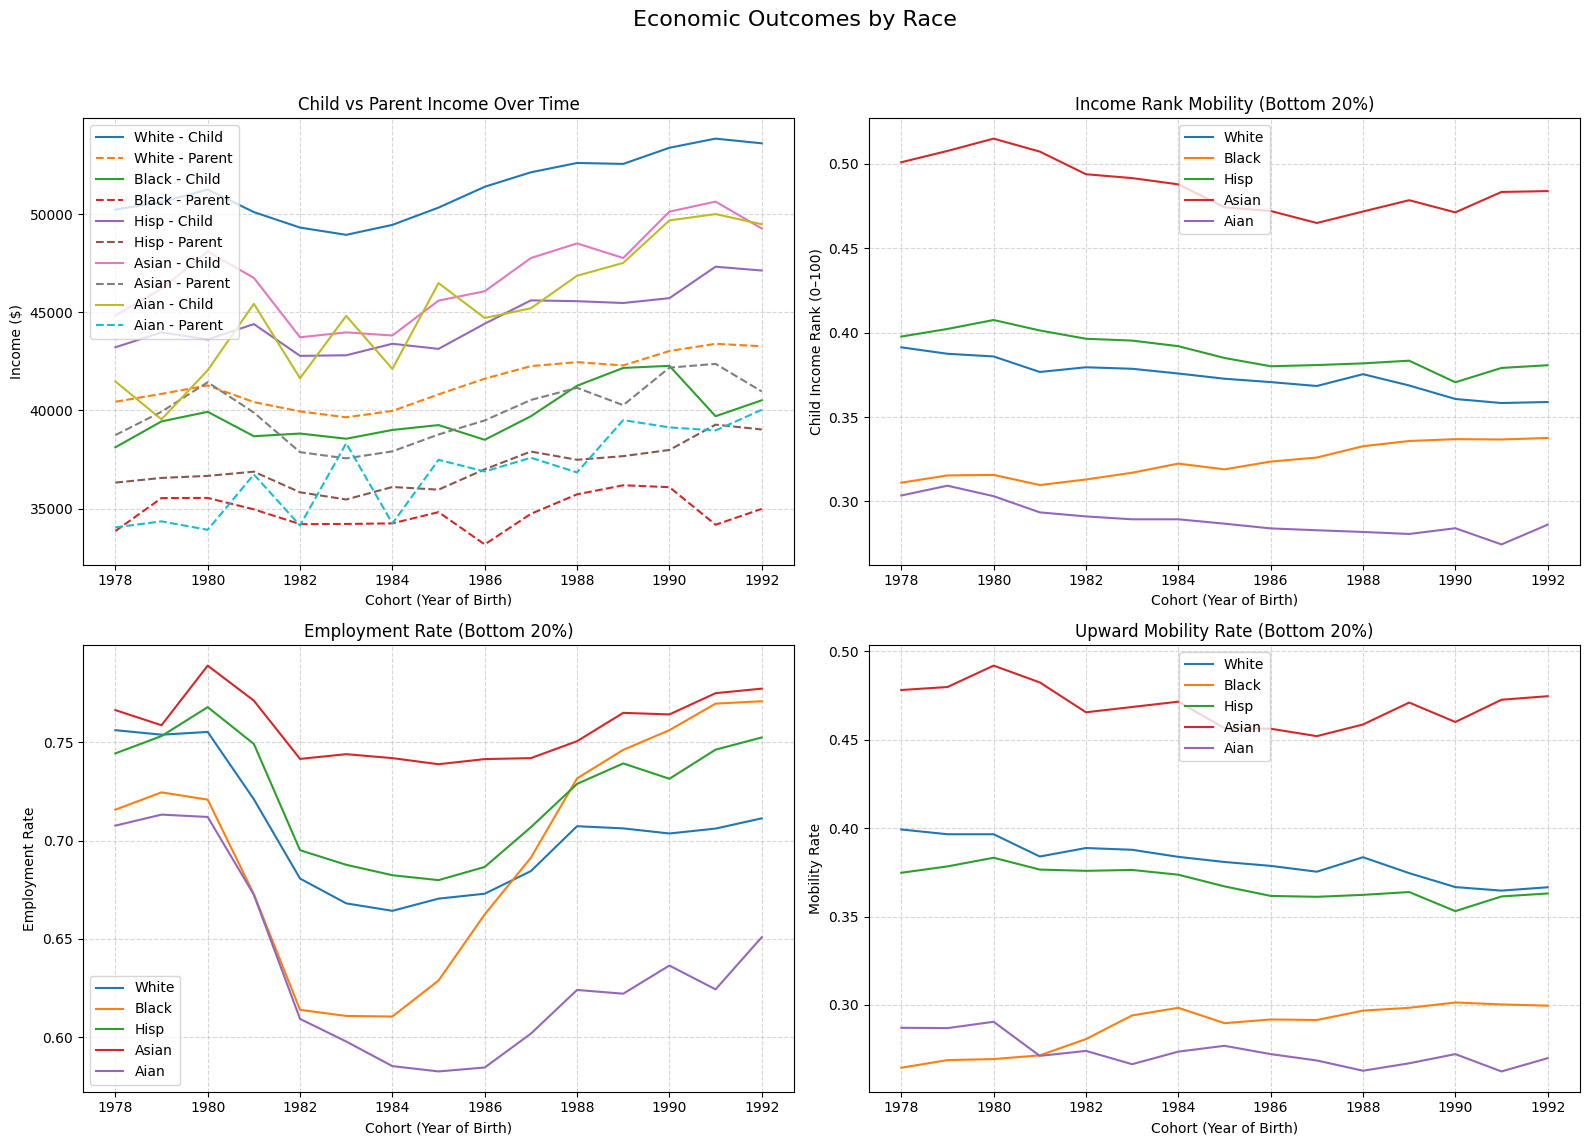

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = read_data("Table_5_national_estimates_by_cohort_primary_outcomes.csv")

# Define the racial groups included in the plots
races = ["white", "black", "hisp", "asian", "aian"]

# Set up a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Economic Outcomes by Race", fontsize=16)

# -----------------------------------------------
# Plot 1: Child vs Parent Income by Race
# Purpose: Compare the average income of children vs. their parents across racial groups
# Notes:
# - "kfi_*" = mean child income
# - "kii_*" = mean parent income
# - Dashed lines = parent income; Solid lines = child income
# -----------------------------------------------
ax = axs[0, 0]
for race in races:
    ax.plot(df["cohort"], df[f"kfi_{race}_pooled_p100"], label=f"{race.capitalize()} - Child")
    ax.plot(df["cohort"], df[f"kii_{race}_pooled_p100"], linestyle="--", label=f"{race.capitalize()} - Parent")
ax.set_title("Child vs Parent Income Over Time")
ax.set_xlabel("Cohort (Year of Birth)")
ax.set_ylabel("Income ($)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

# -----------------------------------------------
# Plot 2: Income Rank Mobility by Race
# Purpose: Show the average national income rank children achieve if born in the bottom 20%
# Notes:
# - "kir_*_pooled_p1" = average child income rank for lowest-income parents
# - Higher rank = more upward mobility
# -----------------------------------------------
ax = axs[0, 1]
for race in races:
    ax.plot(df["cohort"], df[f"kir_{race}_pooled_p1"], label=race.capitalize())
ax.set_title("Income Rank Mobility (Bottom 20%)")
ax.set_xlabel("Cohort (Year of Birth)")
ax.set_ylabel("Child Income Rank (0–100)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

# -----------------------------------------------
# Plot 3: Employment Rate at Bottom 20% by Race
# Purpose: Show labor market engagement among adults from low-income families
# Notes:
# - "emp_*_pooled_p1" = employment rate for individuals from bottom quintile
# - Indicates economic participation
# -----------------------------------------------
ax = axs[1, 0]
for race in races:
    ax.plot(df["cohort"], df[f"emp_{race}_pooled_p1"], label=race.capitalize())
ax.set_title("Employment Rate (Bottom 20%)")
ax.set_xlabel("Cohort (Year of Birth)")
ax.set_ylabel("Employment Rate")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

# -----------------------------------------------
# Plot 4: Upward Mobility Rate by Race
# Purpose: Visualize the fraction of children born in the bottom 20% who reach the top 20%
# Notes:
# - "kfr_*_pooled_p1" = mobility rate from bottom to top quintile
# - A direct measure of intergenerational mobility
# -----------------------------------------------
ax = axs[1, 1]
for race in races:
    ax.plot(df["cohort"], df[f"kfr_{race}_pooled_p1"], label=race.capitalize())
ax.set_title("Upward Mobility Rate (Bottom 20%)")
ax.set_xlabel("Cohort (Year of Birth)")
ax.set_ylabel("Mobility Rate")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

# Final layout adjustment
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

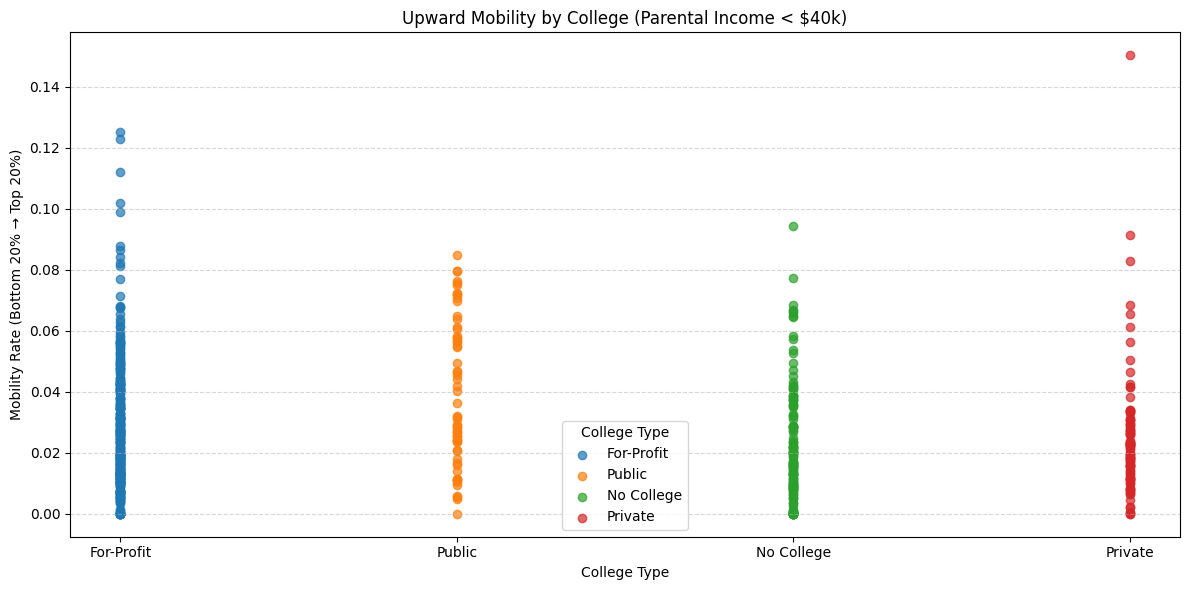

In [4]:
import polars as pl
import matplotlib.pyplot as plt
import pyarrow

# Load dataset
df = read_data("mrc_table3.csv")

# Filter to colleges where average parental income < $40,000
df = df.filter(pl.col("par_mean") < 40000)

# Assign college types based on 'tier'
df = df.with_columns([
    pl.when(pl.col("tier") == 1).then(pl.lit("Ivy-League"))
     .when(pl.col("tier").is_in([3, 5, 7])).then(pl.lit("Public"))
     .when(pl.col("tier").is_in([4, 6, 8])).then(pl.lit("Private"))
     .when(pl.col("tier").is_in([10, 11])).then(pl.lit("For-Profit"))
     .when(pl.col("tier").is_in([12,13,14])).then(pl.lit("No College"))
     .otherwise(None)
     .alias("college_type")
])

# Filter out rows where college_type couldn't be assigned
df_filtered = df.filter(pl.col("college_type").is_not_null())

# Convert to pandas for plotting
df_pd = df_filtered.select(["name", "mr_kq5_pq1", "college_type"]).to_pandas()

# Plot
plt.figure(figsize=(12, 6))
for ctype in df_pd["college_type"].unique():
    sub_df = df_pd[df_pd["college_type"] == ctype]
    plt.scatter(sub_df["college_type"], sub_df["mr_kq5_pq1"], label=ctype, alpha=0.7)

plt.title("Upward Mobility by College (Parental Income < $40k)")
plt.ylabel("Mobility Rate (Bottom 20% → Top 20%)")
plt.xlabel("College Type")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="College Type")
plt.tight_layout()


In [15]:
pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 8.9 MB/s eta 0:00:0000:0100:01m

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
"""
Plot/Action: Rank Colleges by Mobility Rate for a Specific Cohort

Purpose:
- Identify which colleges have the highest upward mobility rates
  (measured as the probability a child born in the bottom 20% reaches the top 20%).

Steps:
- Filter for a specific cohort (e.g., 1985).
- Sort colleges descending by `mobility_rate`.
- Display key columns: college name, mobility rate, parental and child mean income.

Usage:
- Change `cohort` year to examine other birth cohorts.
- Use output for leaderboard tables, highlighting top-mobility colleges.

"""

# Filter for 1985 cohort
df_1985 = df.filter(pl.col("cohort") == 1985)

# Sort and select
top_colleges = df_1985.sort("mobility_rate", descending=True).select(
    ["name", "mobility_rate", "parent_mean_income", "kid_mean_income"]
)

import ace_tools as tools; tools.display_dataframe_to_user(name="Top Colleges by Mobility Rate (Cohort 1985)", dataframe=top_colleges)



ColumnNotFoundError: "mobility_rate" not found

In [6]:
import polars as pl

# Load the dataset
df = read_data("mrc_table3.csv")

# Quick look at the first few rows
print(df.head())
print(df.columns)


shape: (5, 84)
┌─────────────┬────────┬────────────┬──────┬───┬────────────┬────────────┬────────────┬────────────┐
│ super_opeid ┆ cohort ┆ name       ┆ type ┆ … ┆ k_married_ ┆ k_married_ ┆ k_married_ ┆ k_married_ │
│ ---         ┆ ---    ┆ ---        ┆ ---  ┆   ┆ cond_parq2 ┆ cond_parq3 ┆ cond_parq4 ┆ cond_parq5 │
│ i64         ┆ i64    ┆ str        ┆ f64  ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│             ┆        ┆            ┆      ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
╞═════════════╪════════╪════════════╪══════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 30955       ┆ 1980   ┆ ASA        ┆ 3.0  ┆ … ┆ null       ┆ null       ┆ null       ┆ null       │
│             ┆        ┆ Institute  ┆      ┆   ┆            ┆            ┆            ┆            │
│             ┆        ┆ Of         ┆      ┆   ┆            ┆            ┆            ┆            │
│             ┆        ┆ Business & ┆      ┆   ┆            ┆            ┆  

In [7]:
# Keep only students who attended college
df = df.filter(pl.col("super_opeid") > 0)

# Optional: Focus on a particular cohort (say 1985)
df_1985 = df.filter(pl.col("cohort") == 1985)

# Rename key columns for easy reference
df = df.rename({
    "mr_kq5_pq1": "mobility_rate",
    "mr_ktop1_pq1": "upper_tail_mobility",
    "par_mean": "parent_mean_income",
    "k_mean": "kid_mean_income",
})

# Drop rows with missing values in key columns
df = df.drop_nulls(["mobility_rate", "parent_mean_income", "kid_mean_income"])


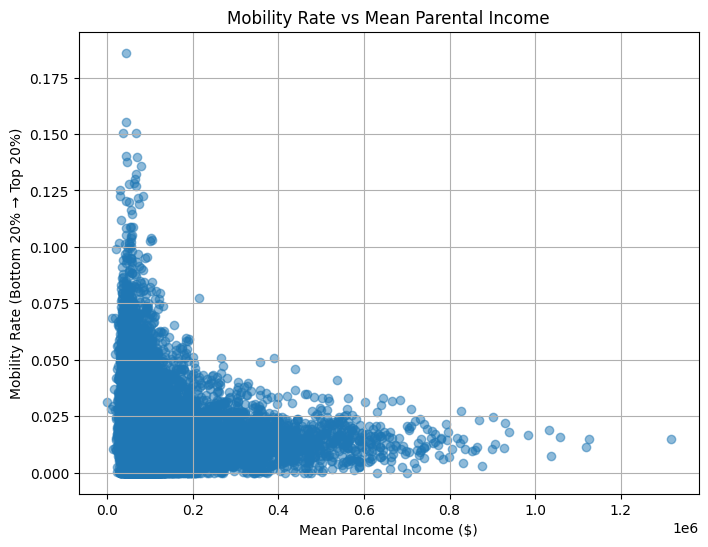

In [8]:
import matplotlib.pyplot as plt

df_pd = df.to_pandas()

plt.figure(figsize=(8,6))
plt.scatter(df_pd["parent_mean_income"], df_pd["mobility_rate"], alpha=0.5)
plt.title("Mobility Rate vs Mean Parental Income")
plt.xlabel("Mean Parental Income ($)")
plt.ylabel("Mobility Rate (Bottom 20% → Top 20%)")
plt.grid(True)
plt.show()


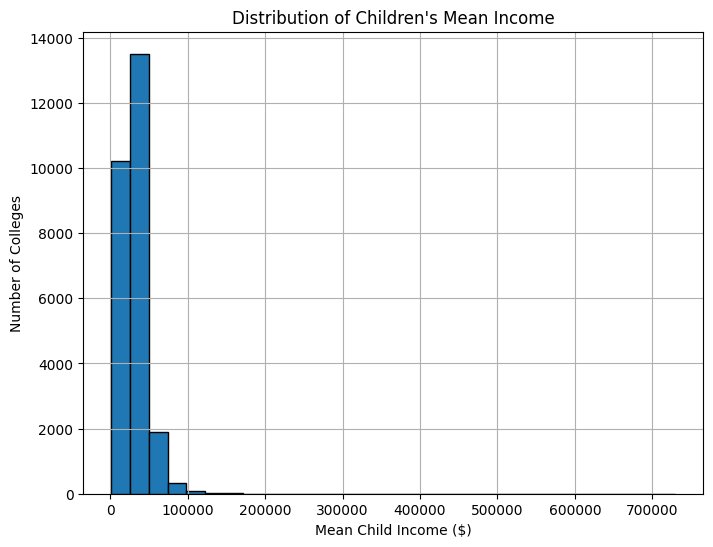

In [9]:
plt.figure(figsize=(8,6))
plt.hist(df_pd["kid_mean_income"], bins=30, edgecolor='black')
plt.title("Distribution of Children's Mean Income")
plt.xlabel("Mean Child Income ($)")
plt.ylabel("Number of Colleges")
plt.grid(True)
plt.show()


<Figure size 800x600 with 0 Axes>

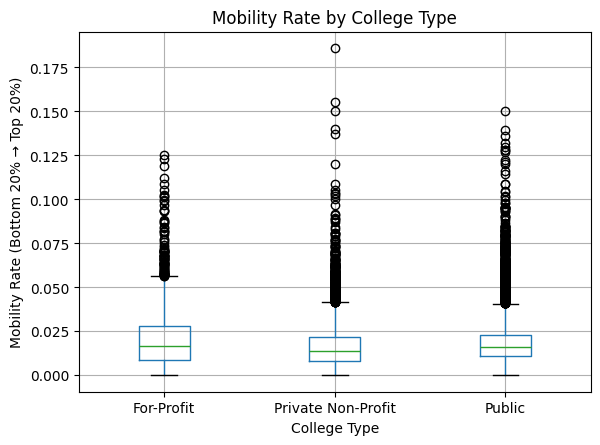

In [10]:
# Map type codes to labels
df_pd["college_type"] = df_pd["type"].map({1: "Public", 2: "Private Non-Profit", 3: "For-Profit"})

# Boxplot
plt.figure(figsize=(8,6))
df_pd.boxplot(column="mobility_rate", by="college_type")
plt.title("Mobility Rate by College Type")
plt.suptitle("")  # Suppress default title
plt.xlabel("College Type")
plt.ylabel("Mobility Rate (Bottom 20% → Top 20%)")
plt.grid(True)
plt.show()

In [12]:
pip install ace_tools


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:

# Filter for a single cohort, e.g., 1985
df_1985 = df.filter(pl.col("cohort") == 1985)

# Rank colleges by mobility rate
top_colleges = df_1985.sort("mobility_rate", descending=True).select(
    ["name", "mobility_rate", "parent_mean_income", "kid_mean_income"]
)

import ace_tools as tools; 
tools.display_dataframe_to_user(name="Top Colleges by Mobility Rate (Cohort 1985)", dataframe=top_colleges)



ModuleNotFoundError: No module named 'ace_tools'

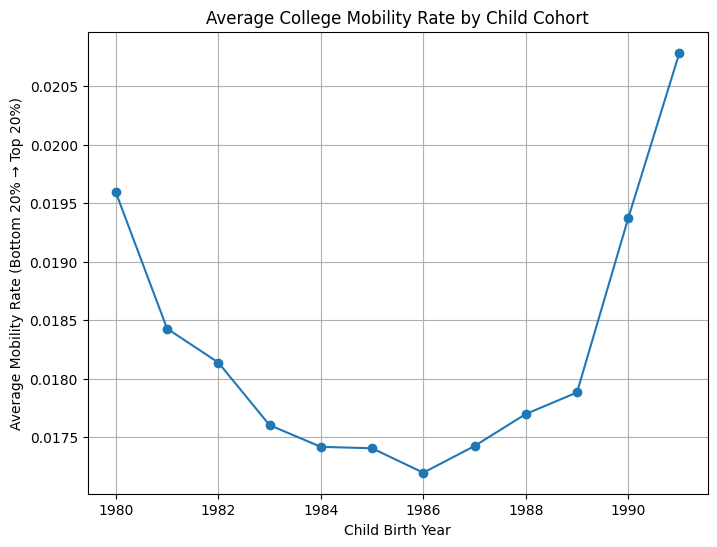

In [15]:
# Group by cohort and compute average mobility
cohort_trend = df.group_by("cohort").agg(
    pl.col("mobility_rate").mean().alias("avg_mobility_rate")
)

# Convert to pandas for plotting
cohort_trend_pd = cohort_trend.sort("cohort").to_pandas()

# Plot
plt.figure(figsize=(8,6))
plt.plot(cohort_trend_pd["cohort"], cohort_trend_pd["avg_mobility_rate"], marker='o')
plt.title("Average College Mobility Rate by Child Cohort")
plt.xlabel("Child Birth Year")
plt.ylabel("Average Mobility Rate (Bottom 20% → Top 20%)")
plt.grid(True)
plt.show()


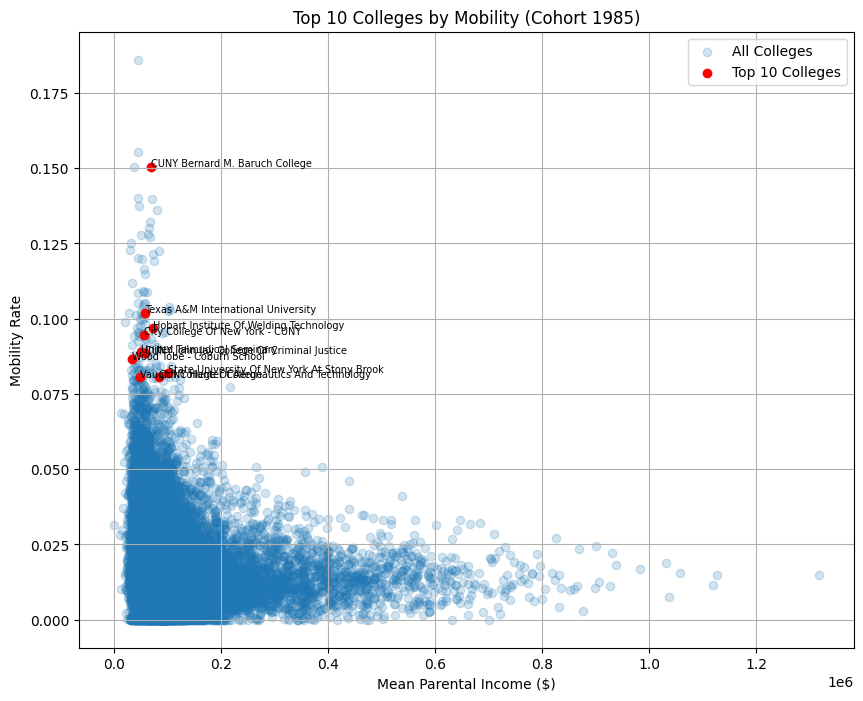

In [16]:
# Top 10 mobility colleges
top10 = df_1985.sort("mobility_rate", descending=True).head(10).to_pandas()

plt.figure(figsize=(10,8))
plt.scatter(df_pd["parent_mean_income"], df_pd["mobility_rate"], alpha=0.2, label="All Colleges")
plt.scatter(top10["parent_mean_income"], top10["mobility_rate"], color='red', label="Top 10 Colleges")

# Annotate
for idx, row in top10.iterrows():
    plt.text(row["parent_mean_income"], row["mobility_rate"], row["name"], fontsize=7)

plt.title("Top 10 Colleges by Mobility (Cohort 1985)")
plt.xlabel("Mean Parental Income ($)")
plt.ylabel("Mobility Rate")
plt.legend()
plt.grid(True)
plt.show()


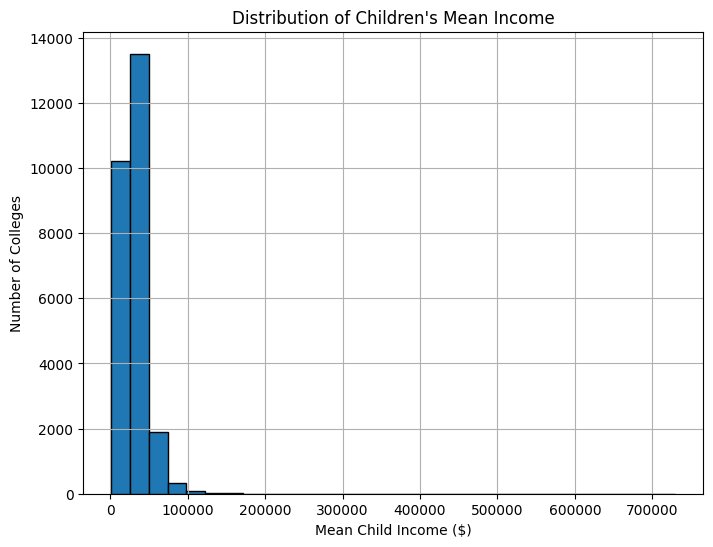

In [21]:
"""
Plot: Histogram of Children's Mean Earnings Across Colleges

Purpose:
- Understand the distribution of average earnings for college students as adults.
- Spot income gaps between colleges.

Steps:
- x-axis: Mean child income.
- y-axis: Number of colleges.
- Histogram with 30 bins.

Usage:
- Identify whether most colleges cluster at low, middle, or high income levels.
- Look for bimodal or skewed distributions.

"""

plt.figure(figsize=(8,6))
plt.hist(df_pd["kid_mean_income"], bins=30, edgecolor='black')
plt.title("Distribution of Children's Mean Income")
plt.xlabel("Mean Child Income ($)")
plt.ylabel("Number of Colleges")
plt.grid(True)
plt.show()


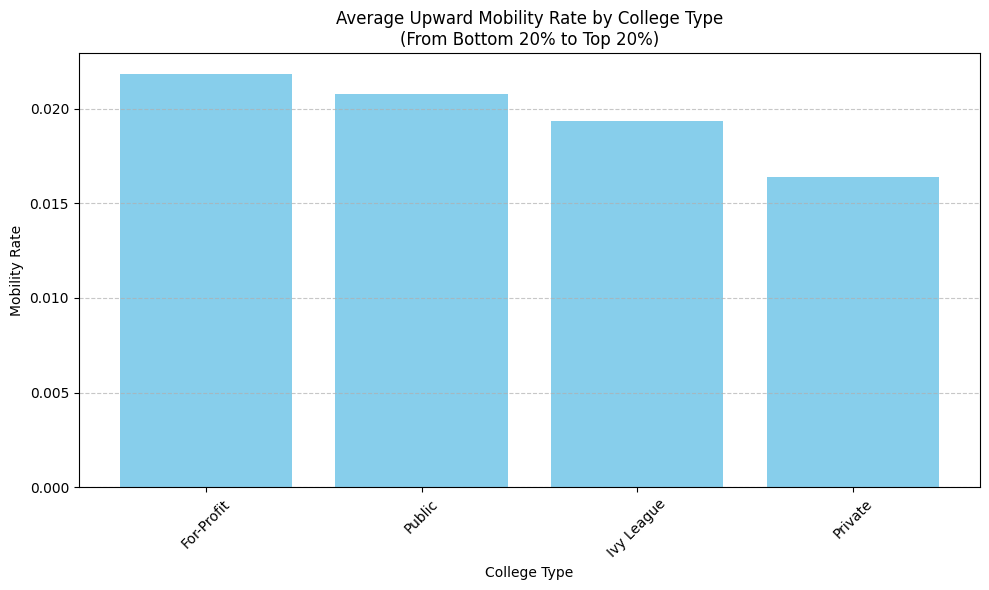

In [23]:
df = pd.read_csv(directory_raw + "mrc_table3.csv")

tier_mapping = {
    1: "Ivy Plus",
    2: "Other Elite",
    3: "Highly Selective Public",
    4: "Highly Selective Private",
    5: "Selective Public",
    6: "Selective Private",
    7: "Nonselective Public",
    8: "Nonselective Private",
    9: "Two-Year Colleges",
    10: "Four-Year For-Profit",
    11: "Two-Year For-Profit",
    12: "Less than Two-Year",
    13: "Insufficient Data",
    14: "Not in College"
}

# Create a new column with tier labels
df["tier_label"] = df["tier"].map(tier_mapping)

# Define the broad categories you want to analyze
category_mapping = {
    "Ivy Plus": "Ivy League",
    "Highly Selective Public": "Public",
    "Selective Public": "Public",
    "Nonselective Public": "Public",
    "Highly Selective Private": "Private",
    "Selective Private": "Private",
    "Nonselective Private": "Private",
    "Four-Year For-Profit": "For-Profit",
    "Two-Year For-Profit": "For-Profit",
}

# Filter to rows we care about and map categories
df = df[df["tier_label"].isin(category_mapping.keys())].copy()
df["college_type"] = df["tier_label"].map(category_mapping)

# Group by college type and calculate mean upward mobility
mobility_by_type = df.groupby("college_type")["mr_kq5_pq1"].mean().reset_index()

# Sort for better visualization
mobility_by_type = mobility_by_type.sort_values("mr_kq5_pq1", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(mobility_by_type["college_type"], mobility_by_type["mr_kq5_pq1"], color='skyblue')
plt.title("Average Upward Mobility Rate by College Type\n(From Bottom 20% to Top 20%)")
plt.ylabel("Mobility Rate")
plt.xlabel("College Type")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

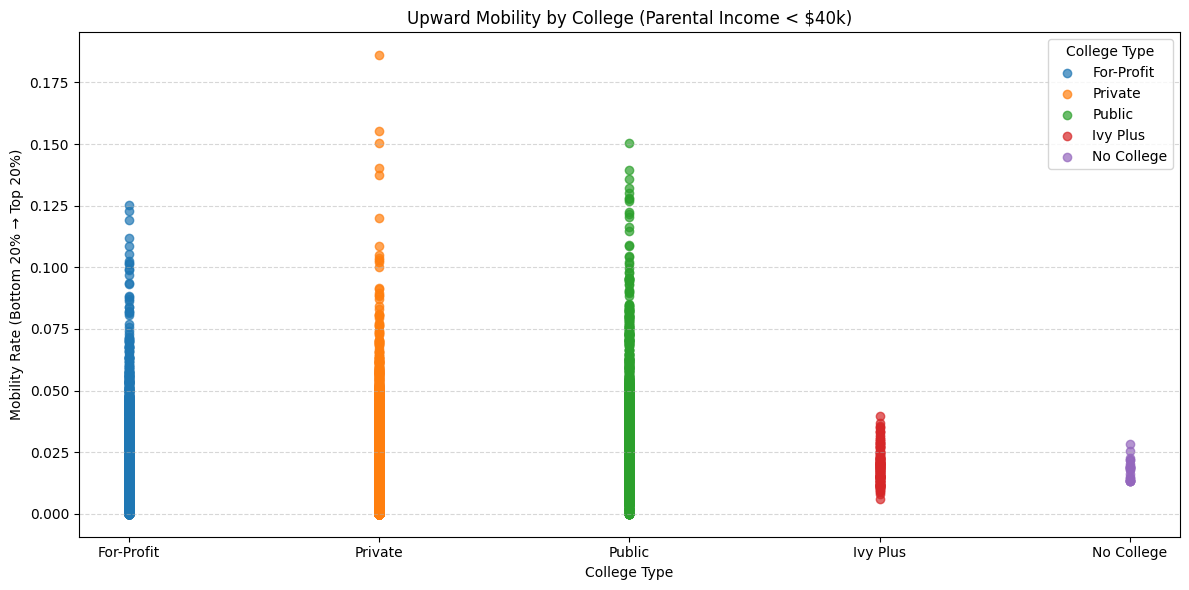

In [44]:
import polars as pl
import matplotlib.pyplot as plt

# STEP 1: Load CSV data
df = read_data("mrc_table3.csv")  # Make sure your file is in the same directory

# STEP 2: Assign readable tier labels based on 'tier' values
df = df.with_columns(
    pl.when(pl.col("tier") == 1).then(pl.lit("Ivy Plus"))
     .when(pl.col("tier").is_in([3, 5, 7])).then(pl.lit("Public"))
     .when(pl.col("tier").is_in([4, 6, 8])).then(pl.lit("Private"))
     .when(pl.col("tier").is_in([10, 11])).then(pl.lit("For-Profit"))
     .when(pl.col("tier").is_in([13,14])).then(pl.lit("No College"))
     .otherwise(pl.lit(None))
     .alias("college_type")
)

# Filter out rows where college_type couldn't be assigned
df_filtered = df.filter(pl.col("college_type").is_not_null())

# Convert to pandas for plotting
df_pd = df_filtered.select(["name", "mr_kq5_pq1", "college_type"]).to_pandas()

# Plot
plt.figure(figsize=(12, 6))
for ctype in df_pd["college_type"].unique():
    sub_df = df_pd[df_pd["college_type"] == ctype]
    plt.scatter(sub_df["college_type"], sub_df["mr_kq5_pq1"], label=ctype, alpha=0.7)

plt.title("Upward Mobility by College (Parental Income < $40k)")
plt.ylabel("Mobility Rate (Bottom 20% → Top 20%)")
plt.xlabel("College Type")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="College Type")
plt.tight_layout()


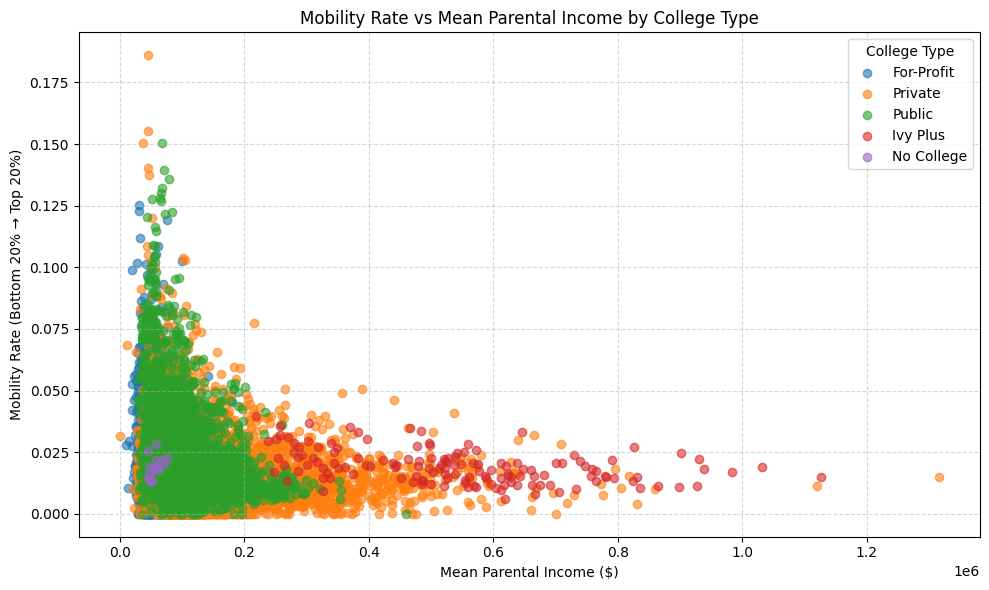

In [45]:
# Convert filtered Polars DataFrame to pandas
df_pd = df_filtered.select(["par_mean", "mr_kq5_pq1", "college_type"]).to_pandas()

# Plot
plt.figure(figsize=(10, 6))
for ctype in df_pd["college_type"].unique():
    sub_df = df_pd[df_pd["college_type"] == ctype]
    plt.scatter(sub_df["par_mean"], sub_df["mr_kq5_pq1"], label=ctype, alpha=0.6)

plt.title("Mobility Rate vs Mean Parental Income by College Type")
plt.xlabel("Mean Parental Income ($)")
plt.ylabel("Mobility Rate (Bottom 20% → Top 20%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="College Type")
plt.tight_layout()
plt.show()

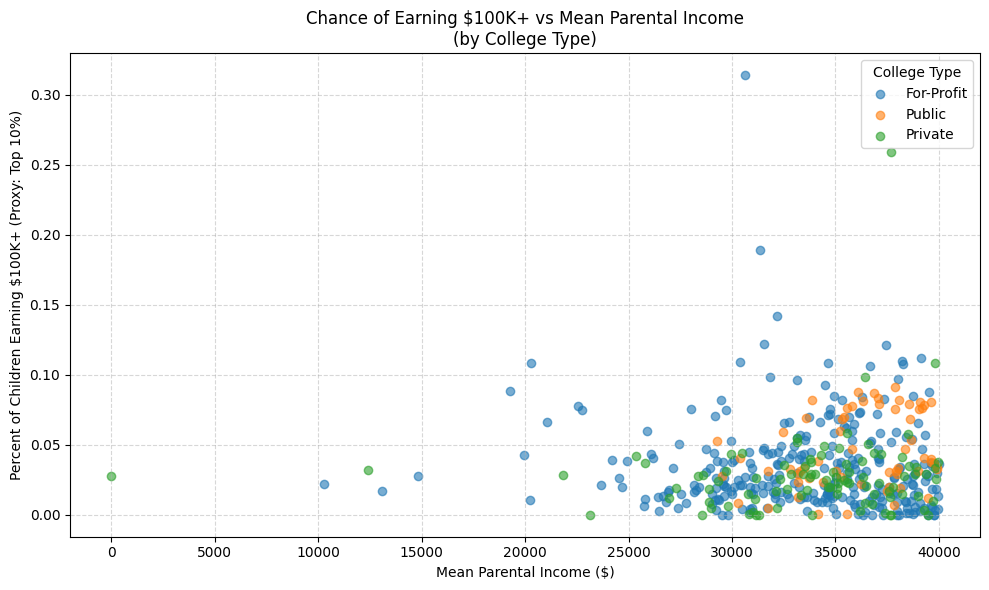

In [35]:
import matplotlib.pyplot as plt

# Convert filtered Polars DataFrame to pandas
df_pd = df_filtered.select(["par_mean", "k_top10pc", "college_type"]).to_pandas()

plt.figure(figsize=(10, 6))
for ctype in df_pd["college_type"].unique():
    sub_df = df_pd[df_pd["college_type"] == ctype]
    plt.scatter(sub_df["par_mean"], sub_df["k_top10pc"], label=ctype, alpha=0.6)

plt.title("Chance of Earning $100K+ vs Mean Parental Income\n(by College Type)")
plt.xlabel("Mean Parental Income ($)")
plt.ylabel("Percent of Children Earning $100K+ (Proxy: Top 10%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="College Type")
plt.tight_layout()
plt.show()


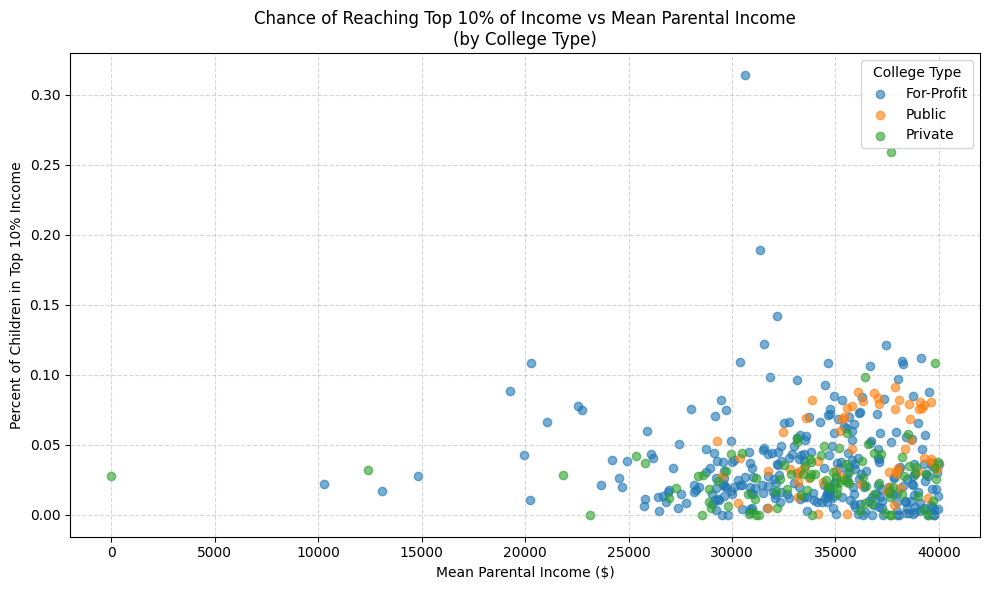

In [34]:
import polars as pl
import matplotlib.pyplot as plt

# STEP 1: Load the dataset
df = read_data("mrc_table3.csv")

# STEP 2: Filter for low parental income (< $40,000), optional
df = df.filter(pl.col("par_mean") < 40000)

# STEP 3: Assign college types using 'tier'
df = df.with_columns(
    pl.when(pl.col("tier") == 1).then(pl.lit("Ivy League"))
     .when(pl.col("tier").is_in([3, 5, 7])).then(pl.lit("Public"))
     .when(pl.col("tier").is_in([4, 6, 8])).then(pl.lit("Private"))
     .when(pl.col("tier").is_in([10, 11])).then(pl.lit("For-Profit"))
     .otherwise(pl.lit(None))
     .alias("college_type")
)

# STEP 4: Filter out rows without a college_type or k_top10pc
df_filtered = df.filter(
    (pl.col("college_type").is_not_null()) &
    (pl.col("k_top10pc").is_not_null())
)

# STEP 5: Convert to pandas for plotting
df_pd = df_filtered.select(["par_mean", "k_top10pc", "college_type"]).to_pandas()

# STEP 6: Plot
plt.figure(figsize=(10, 6))
for ctype in df_pd["college_type"].unique():
    sub_df = df_pd[df_pd["college_type"] == ctype]
    plt.scatter(sub_df["par_mean"], sub_df["k_top10pc"], label=ctype, alpha=0.6)

plt.title("Chance of Reaching Top 10% of Income vs Mean Parental Income\n(by College Type)")
plt.xlabel("Mean Parental Income ($)")
plt.ylabel("Percent of Children in Top 10% Income")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="College Type")
plt.tight_layout()
plt.show()


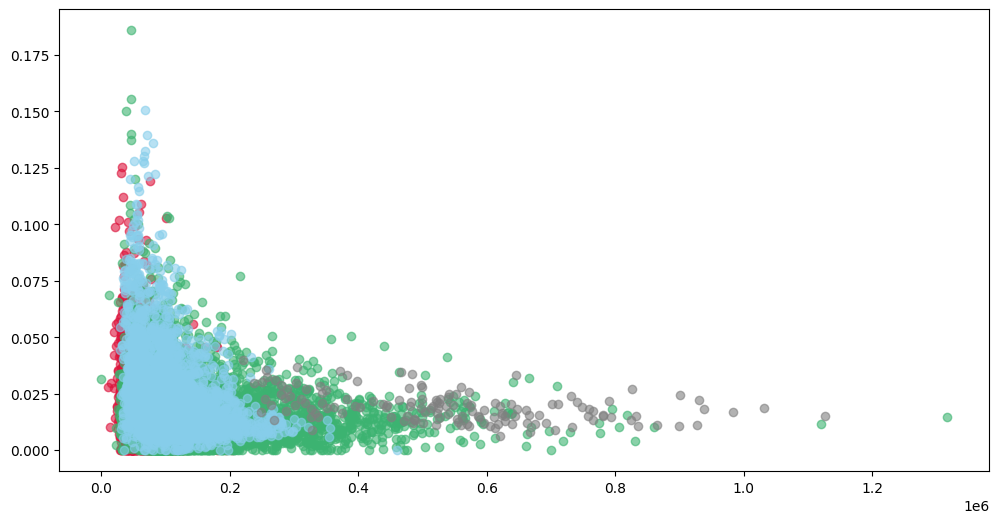

In [ ]:
# Define custom colors for each college type
color_map = {
    "Ivy League": "gold",
    "Public": "skyblue",
    "Private": "mediumseagreen",
    "For-Profit": "yellow"
    ""  # Brighter red to stand out
}

# Plot each group with its custom color
plt.figure(figsize=(12, 6))
for ctype in df_pd["college_type"].unique():
    sub_df = df_pd[df_pd["college_type"] == ctype]
    plt.scatter(
        sub_df["par_mean"],
        sub_df["mr_kq5_pq1"],
        label=ctype,
        alpha=0.6,
        color=color_map.get(ctype, "gray")
    )